Showing gain control can create anticipative signals
by using both HMM and LPOU signal

created by ckc on Sept 9, 2021

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy import signal
from scipy.fftpack import fft, fftfreq
from scipy.io import loadmat
from scipy.signal import savgol_filter
%matplotlib inline
from random import gauss

In [39]:
# HMM signal generator

def HMM_Gen(G_HMM,D_HMM,xmax,xmin,T,dt):
# time is in second

    nstep=int(T/dt)

# HMM model parameters
#    G_HMM = 4; 
#    D_HMM = 2700000;     #dynamical range
    omega =G_HMM/2.12;   # omega = G/(2w)=1.06; follow Bialek's overdamped dynamics/ 2015PNAS

# generate the stochastic sequence in x
    x = np.zeros(nstep)
    v = np.zeros(nstep)
    x[0] = 0.0
    v[0] = 0.0
    for i in range(1,nstep):
        x[i] = x[i-1] + v[i-1]*dt
        v[i] = (1-G_HMM*dt)*v[i-1]-omega**2*x[i-1]*dt + gauss(0,1)*np.sqrt(D_HMM*dt)
    maxval = np.max(x)
    minval = np.min(x)
    ratio = 1./(maxval-minval)
    for i in range(nstep):
        x[i] = xmin+(x[i]-minval)*ratio*(xmax-xmin)
    return x

In [40]:
Tot=300
dt=0.001
tAxis=np.arange(dt,Tot,dt)
D = 1

# # OU
# tau=0.6

# L=np.zeros_like(tAxis)
# mu, sigma = 0, 1
# for i in range(len(tAxis)-1):
#     L[i+1]=L[i]*(1-dt/tau)+math.sqrt(D*dt)*np.random.normal(mu,sigma)

# # filtering
# fc=0.6
# b, a = signal.butter(2, 2*fc*dt, btype='low', analog=False)
# LPOU = signal.filtfilt(b, a, L)

#
G = 0.1
HMM = np.zeros_like(tAxis)
HMMv = np.zeros_like(tAxis)

omega =G/2.12
for i in range(len(tAxis)-1):
    HMM[i+1] = HMM[i] + HMMv[i]*dt
    HMMv[i+1] = (1-G*dt)*HMMv[i]-omega**2*HMM[i]*dt + gauss(0,1)*np.sqrt(D*dt)



In [41]:
x = LPOU

x = (x-min(x))/(max(x)-min(x))*1

In [42]:
#AGC
y = np.zeros_like(x)
gain =np.ones_like(x)
delay = int(10/0.05)
tau = delay*dt
for i in range(delay,len(x)):
    gain[i] = 1/(1+y[i-delay]**2)
    y[i]= gain[i]*x[i]

(150.0, 160.0)

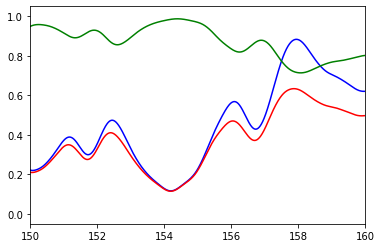

In [43]:
plt.plot(tAxis,x,'b')
plt.plot(tAxis,y,'r')
plt.plot(tAxis,gain,'g')
plt.xlim(150,160 )
# plt.xlim(100,110)

In [44]:
# xAutoConvolve = np.convolve( x-np.mean(x), x-np.mean(x), 'same' )
xAutoCorrelate = np.correlate( x-np.mean(x), x-np.mean(x), 'same' )
xyCorrelate = np.correlate( x-np.mean(x), y-np.mean(y), 'same' )

(148000.0, 152000.0)

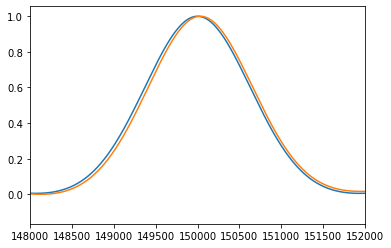

In [55]:
# plt.plot(xAutoConvolve)
plt.plot( xAutoCorrelate/max(xAutoCorrelate) )
plt.plot( xyCorrelate/max(xyCorrelate) )
plt.xlim(148000, 152000)

In [46]:
def FFT_quick(data, dt, center_data = False, center_faxis = True):
    if center_data:
        xft=fft(data-np.mean(data))
    else:
        xft=fft(data)
    xft_nor=xft/len(xft)
    freq=fftfreq(len(x), d=dt)

    if center_faxis:
        xft_nor = np.append( xft_nor[np.argmin(freq):],xft_nor[:np.argmin(freq)] )
        freq2 = np.append( freq[np.argmin(freq):], freq[:np.argmin(freq)] )
    return freq2,xft_nor

In [47]:
def angular_gradient(x):
    diffx= np.gradient(x)
    diffx[np.abs(diffx)>0.6*np.pi] -= np.pi*diffx[np.abs(diffx)>0.6*np.pi]/abs(diffx[np.abs(diffx)>0.6*np.pi])
    return diffx

In [48]:
freq,FT_x=FFT_quick(x, dt)
freq,FT_y=FFT_quick(y, dt)
freq,FT_yy=FFT_quick(y**2, dt)
# print(FT_y[freq==0])
# print(FT_x[freq==0])

In [65]:
H = FT_y/FT_x
G = np.abs(H)
Phi = np.angle(H)
delta = -angular_gradient(x)/np.mean(np.diff(freq))
PhaseDelay = -Phi/freq

C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


(0.0, 10.0)

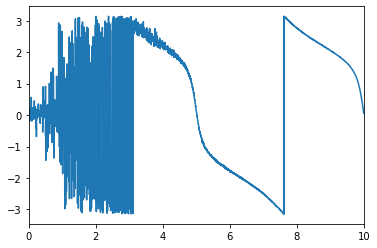

In [69]:
plt.plot(freq,Phi)
# plt.plot(freq, delta)
# plt.plot(freq, G)
# plt.ylim(0,1)
plt.xlim(0,10)

(0.0, 3.0)

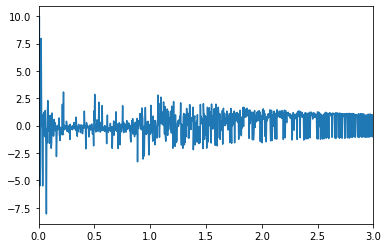

In [68]:
plt.plot(freq,PhaseDelay)
# plt.plot(freq, delta)
# plt.plot(freq, G)
# plt.ylim(0,1)
plt.xlim(0,3)

In [51]:
freq,FT_yy=FFT_quick(y**2, dt)
print(FT_yy[freq==0])

[0.13922016-0.j]


(-0.05, 0.05)

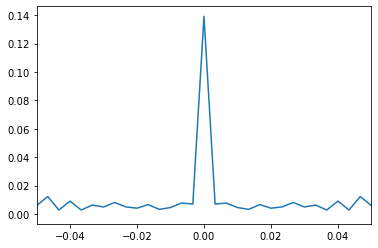

In [52]:
# plt.plot(freq, FT_yy.real)
# plt.plot(freq, FT_yy.imag)
# plt.plot(freq, FT_y.real)
# plt.plot(freq, FT_y.imag)

plt.plot(freq, np.abs(FT_yy))
# plt.plot(freq, np.abs(FT_y))
# plt.plot(freq, np.angle(FT_yy))
plt.xlim(-0.05,0.05)

In [53]:
phaseshift = np.exp(1j*2*np.pi*freq*tau)
Gamma = FT_yy*phaseshift

(-0.05, 0.05)

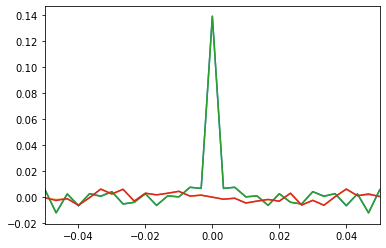

In [54]:
plt.plot(freq, Gamma.real)
plt.plot(freq, Gamma.imag)

plt.plot(freq, FT_yy.real)
plt.plot(freq, FT_yy.imag)

# plt.plot(freq, np.abs(Gamma))
plt.xlim(-0.05,0.05)